In [ ]:
!pip install keras_cv tensorflow-addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 50.9 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.1
    Uninstalling typeguard-4.4.1:
      Successfully uninstalled typeguard-4.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.4.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [ ]:
# Import necessary libraries
from datetime import datetime
from google.colab import drive, files
from keras import backend as K
from PIL import Image
from sklearn.metrics import (
    accuracy_score,  confusion_matrix, ConfusionMatrixDisplay,
    f1_score, precision_score, recall_score
)
from sklearn.model_selection import train_test_split
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

import keras_cv
import logging
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import seaborn as sns
import tensorflow as tf
#import tensorflow_addons as tfa
import tensorflow.keras.backend as K
import warnings

In [ ]:
drive.mount('/gdrive')
%cd /gdrive/My Drive/[2024-2025] AN2DL/Homework 2

Mounted at /gdrive
/gdrive/My Drive/[2024-2025] AN2DL/Homework 2


In [ ]:
# Set seed for reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(f"Keras version is: {tfk.__version__}")
print(f"Tensor flow version is: {tf.__version__}")
#print(f"Tensor flow addonsversion is: {tfa.__version__}")

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

Keras version is: 3.5.0
Tensor flow version is: 2.17.1


In [ ]:
# Set batch size for training
BATCH_SIZE = 256

# Set learning rate for the optimiser
LEARNING_RATE = 1e-4

# Set early stopping patience threshold
PATIENCE = 30

# Set maximum number of training epochs
EPOCHS = 1000

NUM_CLASSES = 5

In [ ]:
#data = np.load("/kaggle/input/mars-dataset/mars_for_students.npz")
data = np.load("mars_for_students.npz")
training_set = data["training_set"]

X_train = training_set[:, 0] # Contains all the original images
y_train = training_set[:, 1] # Contains all the segmented images

X_test = data["test_set"]

## Data cleaning

In [ ]:
# Get the reference label (y_train[62]), it's the label representing the alien
reference_label = y_train[62]

# Filter the dataset where y_train is not equal to the reference label
mask = [not np.array_equal(label, reference_label) for label in y_train]

print(f"Original dataset size: {len(X_train)}")

# We keep only the entries not equal to reference_label
X_train = X_train[mask]
y_train = y_train[mask]

print(f"Filtered dataset size: {len(X_train)}")

Original dataset size: 2615
Filtered dataset size: 2505


Img 1836


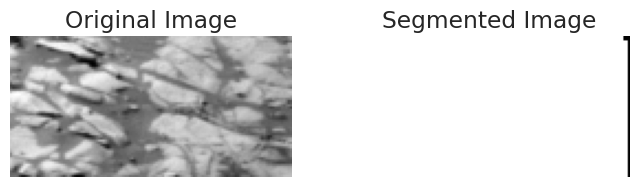

Img 252


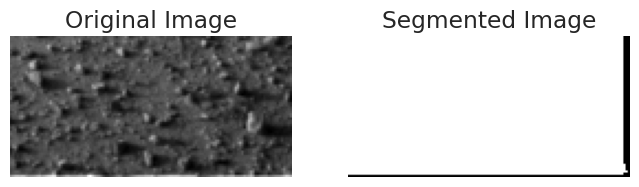

Img 2173


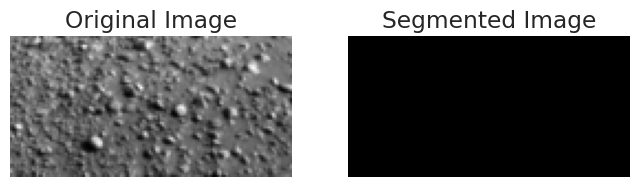

Img 430


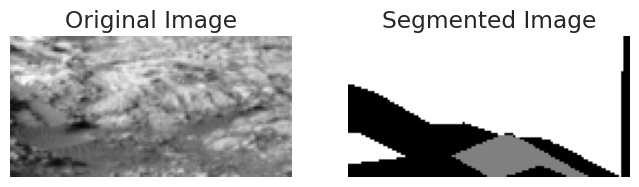

Img 1357


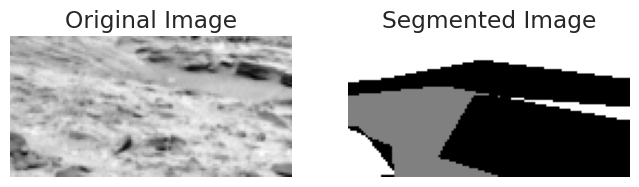

Img 1621


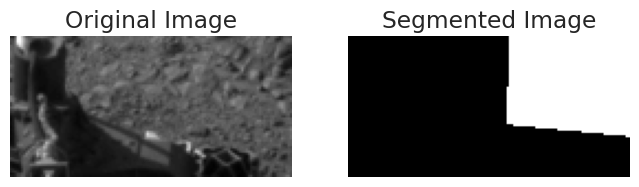

Img 1891


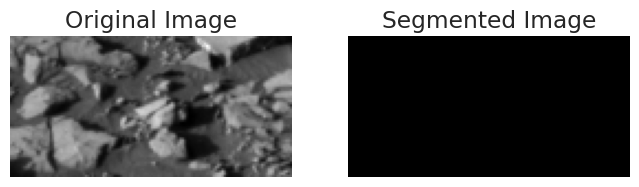

Img 1071


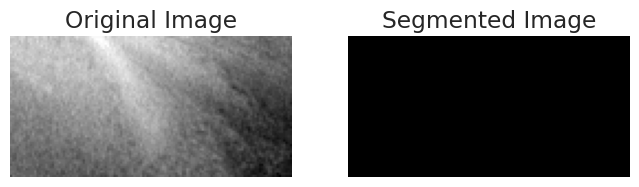

Img 239


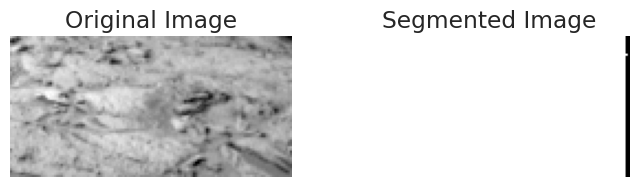

Img 1313


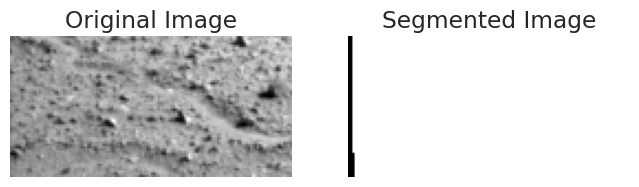

In [ ]:
# Randomly sample 10 indices
random_indices = np.random.choice(len(X_train), size=10, replace=False)

# Loop through the randomly selected images
for i, idx in enumerate(random_indices):
    img = X_train[idx]
    label = y_train[idx]

    plt.figure(figsize=(8, 4))

    print(f"Img {idx}")

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray' if len(img.shape) == 2 else None)
    plt.title("Original Image")
    plt.axis('off')

    # Segmented Image
    plt.subplot(1, 2, 2)
    plt.imshow(label, cmap='gray' if len(label.shape) == 2 else None)
    plt.title("Segmented Image")
    plt.axis('off')

    plt.show()

In [ ]:
# Flatten y_train to aggregate pixel counts across all segmented images
all_pixels = np.concatenate([y.flatten() for y in y_train])

# Count the occurrences of each class
unique_classes, counts = np.unique(all_pixels, return_counts=True)

# Calculate the total number of pixels
total_pixels = all_pixels.size

# Calculate the percentage of each class
class_percentages = {cls: (count / total_pixels) * 100 for cls, count in zip(unique_classes, counts)}

# Print results
print("Class percentages:")
for cls, percentage in class_percentages.items():
    print(f"Class {cls}: {percentage:.2f}%")

Class percentages:
Class 0.0: 24.31%
Class 1.0: 33.90%
Class 2.0: 23.28%
Class 3.0: 18.38%
Class 4.0: 0.13%


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=seed
)

In [ ]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    # Return the transformed tensor
    return x

In [ ]:
def augmentation_layer():
    return tf.keras.Sequential(
        [
          tf.keras.layers.RandomBrightness(factor=0.1),
          keras_cv.layers.RandomContrast(value_range=[0, 255], factor=0.2),
          keras_cv.layers.RandomGaussianBlur(kernel_size=2, factor=1),
          tf.keras.layers.GaussianNoise(stddev=0.05),
        ]
    )

In [ ]:
def get_unet_model(input_shape=(64, 128, 1), num_classes=NUM_CLASSES, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    input_layer = augmentation_layer()(input_layer)

    # Downsampling path
    down_block_1 = unet_block(input_layer, 32, name='down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, 64, name='down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)

    down_block_3 = unet_block(d2, 128, name='down_block3_')  # Additional downsampling block
    d3 = tfkl.MaxPooling2D()(down_block_3)

    down_block_4 = unet_block(d3, 256, name='down_block4_')  # Another additional downsampling block
    d4 = tfkl.MaxPooling2D()(down_block_4)

    # Bottleneck
    bottleneck = unet_block(d4, 512, name='bottleneck')

    # Upsampling path
    u4 = tfkl.UpSampling2D()(bottleneck)
    u4 = tfkl.Concatenate()([u4, down_block_4])
    u4 = unet_block(u4, 256, name='up_block4_')

    u3 = tfkl.UpSampling2D()(u4)
    u3 = tfkl.Concatenate()([u3, down_block_3])
    u3 = unet_block(u3, 128, name='up_block3_')

    u2 = tfkl.UpSampling2D()(u3)
    u2 = tfkl.Concatenate()([u2, down_block_2])
    u2 = unet_block(u2, 64, name='up_block2_')

    u1 = tfkl.UpSampling2D()(u2)
    u1 = tfkl.Concatenate()([u1, down_block_1])
    u1 = unet_block(u1, 32, name='up_block1_')

    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u1)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet')
    return model

In [ ]:
category_map = {
        0: 0,  # unlabelled
        1: 1,
        2: 2,
        3: 3,
        4: 4
}

def apply_category_mapping(label):
    """
    Apply the category mapping to the received label.
    """
    keys_tensor = tf.constant(list(category_map.keys()), dtype=tf.int32)
    vals_tensor = tf.constant(list(category_map.values()), dtype=tf.int32)
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
        default_value=0
    )
    return table.lookup(int(label))

In [ ]:
#@tf.function
def random_augmentations(image, label, seed=None):
    """
    Applies random augmentations to the input image and label (segmentation mask).
    Each augmentation is applied with random intensity and probability.
    Only the augmentations that are applied also to the labels are here
    """

    if seed is None:
        seed = np.random.randint(0, 1000000)

    # Cast to float64 at the start to ensure consistency
    image = tf.cast(image, tf.float64)
    label = tf.cast(label, tf.float64)

    def rotate_fn(image, label, angle):
        # Get image dimensions (using tf.shape to avoid None)
        shape = tf.shape(image)
        height = tf.cast(shape[0], tf.float32)
        width = tf.cast(shape[1], tf.float32)
        channels = shape[2]  # This assumes the image has 3 channels (RGB)

        image = tf.image.rot90(image, k=tf.cast(angle // 90, tf.int32))  # Rotate by multiples of 90 degrees
        label = tf.image.rot90(label, k=tf.cast(angle // 90, tf.int32))  # Rotate by multiples of 90 degrees

        # Ensure both image and label are always resized to the target size
        image = tf.image.resize(image, [height, width])
        label = tf.image.resize(label, [height, width])

        # Cast to float64 at the start to ensure consistency
        image = tf.cast(image, tf.float64)
        label = tf.cast(label, tf.float64)

        return image, label

    def zoom_fn(image, label, factor):
        # Get image dimensions (using tf.shape to avoid None)
        shape = tf.shape(image)
        height = tf.cast(shape[0], tf.float32)
        width = tf.cast(shape[1], tf.float32)
        channels_picture = shape[2]
        shape = tf.shape(label)
        channels_label = shape[2]

        # Calculate the new dimensions based on the factor
        new_height = tf.cast(height * (2 - factor), tf.int32)
        new_width = tf.cast(width * (2 - factor), tf.int32)

        # Crop the image and label randomly to the reduced size
        image = tf.image.random_crop(image, size=[new_height, new_width, channels_picture])
        label = tf.image.random_crop(label, size=[new_height, new_width, channels_label])

        # Ensure both image and label are always resized to the target size
        image = tf.image.resize(image, [height, width])
        label = tf.image.resize(label, [height, width])

        # Cast to float64 at the start to ensure consistency
        image = tf.cast(image, tf.float64)
        label = tf.cast(label, tf.float64)

        return image, label

    # Random flip as in the original function
    flip_prob = tf.random.uniform([], seed=seed)
    image = tf.cond(
        #flip_prob > 0.5,
        flip_prob >= 0.2,
        lambda: tf.image.flip_left_right(image),
        lambda: image
    )

    label = tf.cond(
        #flip_prob > 0.5,
        flip_prob >= 0.2,
        lambda: tf.image.flip_left_right(label),
        lambda: label
    )

    # Random Rotation (rotate by the same angle)
    rotation_prob = tf.random.uniform([], seed=seed)
    angle = tf.random.uniform([], 0, 360, dtype=tf.float32)

    image, label = tf.cond(
        #rotation_prob > 0.5,
        rotation_prob >= 0.2,
        lambda: rotate_fn(image, label, angle),
        lambda: (image, label)
    )

    # Random Zoom (zoom in/out by the same factor)
    zoom_prob = tf.random.uniform([], seed=seed)
    zoom_factor = tf.random.uniform([], 1.1, 1.5)

    image, label = tf.cond(
        #zoom_prob > 0.5,
        zoom_prob >= 0.2,
        lambda: zoom_fn(image, label, zoom_factor),
        lambda: (image, label)
    )

    return image, label

In [ ]:
def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D (collapse the one-hot encoding)
    label = np.argmax(label, axis=-1)  # Convert one-hot encoded to single class labels
    label = np.squeeze(label)  # Remove any singleton dimensions

    # Generate the colormap
    if colormap is None:
        colormap = plt.cm.viridis(np.linspace(0, 1, NUM_CLASSES))  # Create a colormap based on the number of classes

    # Apply the colormap
    colored = colormap[label]  # Apply colormap to the label
    return colored

def visualize_augmented_images(dataset, augmentation_function, num_examples=5, seed=None):
    """
    Visualizes a few examples of original and augmented images and labels side by side.
    Args:
    - dataset: The tf.data.Dataset containing the images and labels.
    - augmentation_function: The function to apply augmentations to images and labels.
    - num_examples: The number of images to visualize.
    - seed: Random seed for reproducibility.
    """

    # Fetch a batch of images from the dataset
    for img_batch, lbl_batch in dataset.take(1):  # Take one batch from the dataset
        original_images = img_batch[:num_examples]
        original_labels = lbl_batch[:num_examples]

        augmented_images = []
        augmented_labels = []

        # Apply augmentations to the images and labels
        for img, lbl in zip(original_images, original_labels):
            augmented_img, augmented_lbl = augmentation_function(img, lbl, seed=seed)
            augmented_images.append(augmented_img)
            augmented_labels.append(augmented_lbl)

        # Convert to numpy arrays for visualization
        augmented_images = np.array(augmented_images)
        augmented_labels = np.array(augmented_labels)

        # Plot original and augmented images and labels side by side
        fig, axes = plt.subplots(num_examples, 4, figsize=(15, 10))  # 4 columns: image, augmented image, label, augmented label
        for i in range(num_examples):
            # Original image and augmented image
            axes[i, 0].imshow(original_images[i].numpy().astype(np.uint8))
            axes[i, 0].set_title("Original Image")
            axes[i, 0].axis('off')
            axes[i, 1].imshow(augmented_images[i].astype(np.uint8))
            axes[i, 1].set_title("Augmented Image")
            axes[i, 1].axis('off')

            # Apply colormap to the labels
            original_label_colored = apply_colormap(original_labels[i].numpy().astype(np.uint8))
            augmented_label_colored = apply_colormap(augmented_labels[i].astype(np.uint8))

            axes[i, 2].imshow(original_label_colored)
            axes[i, 2].set_title("Original Label")
            axes[i, 2].axis('off')
            axes[i, 3].imshow(augmented_label_colored)
            axes[i, 3].set_title("Augmented Label")
            axes[i, 3].axis('off')

        plt.tight_layout()
        plt.show()

In [ ]:
def make_dataset(images, labels, batch_size, shuffle=True, augment=False, seed=None):
    """
    Create a memory-efficient TensorFlow dataset.
    """

    images = tf.expand_dims(images, axis=-1)  # Ensure images have a single channel (grayscale or RGB)

    # One-hot encode the labels and convert to uint8
    labels = tf.cast(labels, tf.uint8)  # Convert labels to uint8
    labels = tf.keras.backend.one_hot(labels, NUM_CLASSES)  # One-hot encoding the labels

    # Create dataset from images and one-hot encoded labels
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    # Apply category mapping if needed (you can modify this function as necessary)
    dataset = dataset.map(
        lambda x, y: (x, apply_category_mapping(y)),  # You can define apply_category_mapping based on your needs
        num_parallel_calls=tf.data.AUTOTUNE
    )

    """if augment:
        dataset = dataset.map(
            lambda x, y: random_augmentations(x, y, seed=seed),  # Define random_augmentations for augmentation if necessary
            num_parallel_calls=tf.data.AUTOTUNE
        )"""

    if augment:
      # Cast labels in the original dataset to float64
      dataset = dataset.map(
          lambda x, y: (x, tf.cast(y, tf.float64)),
          num_parallel_calls=tf.data.AUTOTUNE
      )
      # Create a dataset with augmented images
      augmented_dataset = dataset.map(
          lambda x, y: random_augmentations(x, y, seed=seed),
          num_parallel_calls=tf.data.AUTOTUNE
      )

    # Concatenate the original and augmented datasets
    dataset = dataset.concatenate(augmented_dataset)

    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

Total number of elements in the dataset: 40


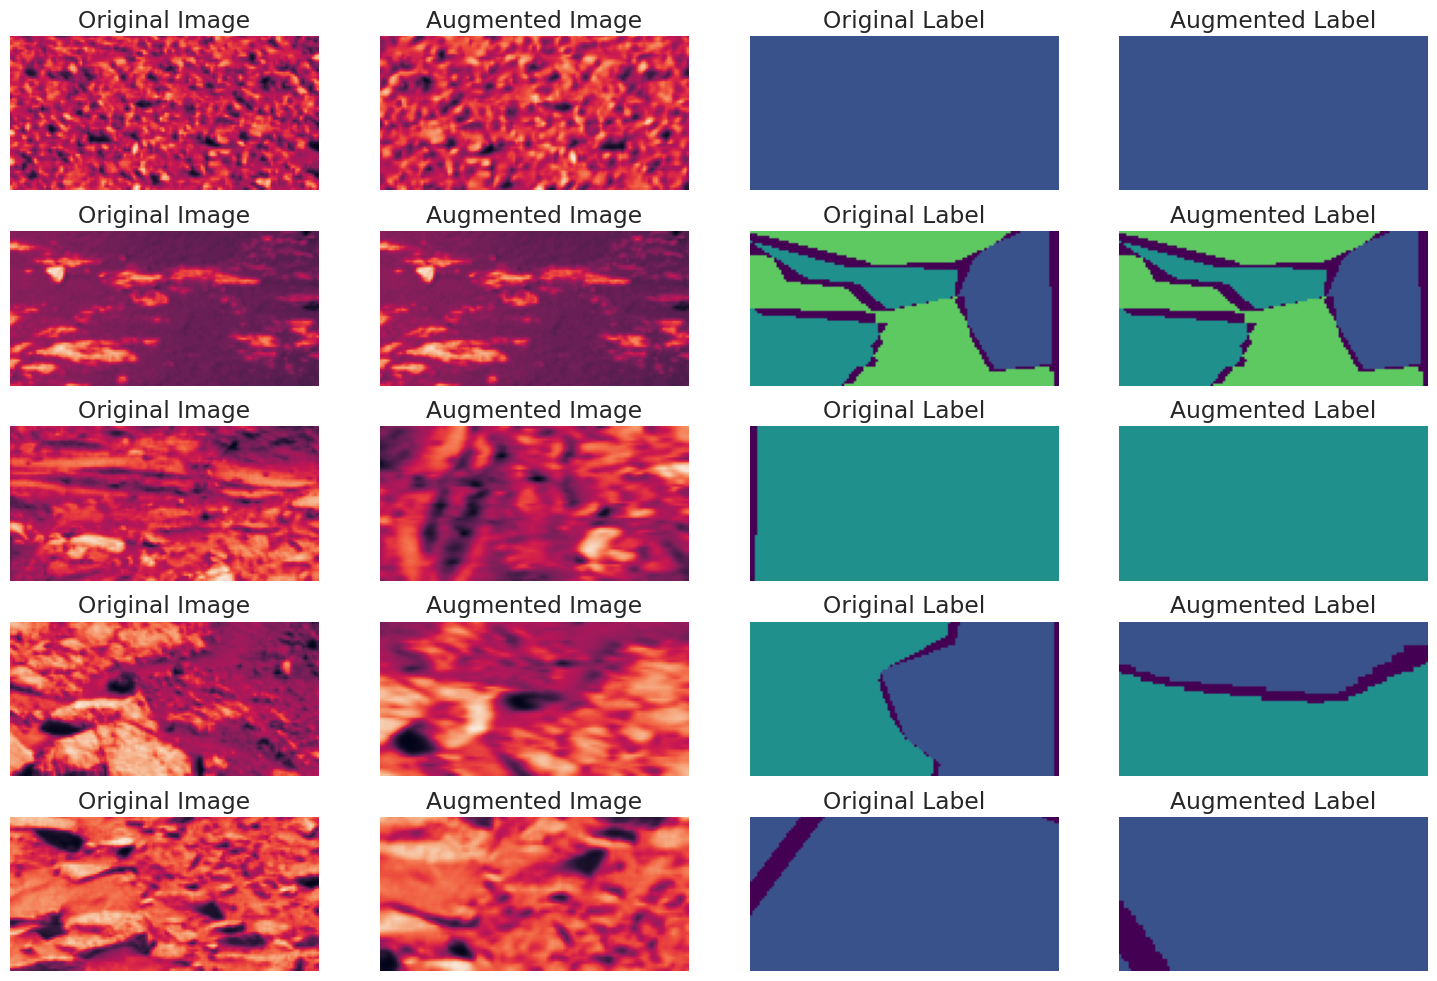

In [ ]:
# Shuffle indices and select 20 random samples
random_indices = np.random.choice(X_train.shape[0], size=20, replace=False)

# Use the random indices to slice the data
X_random = X_train[random_indices]
y_random = y_train[random_indices]

show_dataset = make_dataset(
    X_random, y_random,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=True,
    #augment=False,
    seed=seed
)

# Calculate total elements by iterating through the dataset
num_elements = sum(tf.shape(x)[0].numpy() for x, y in show_dataset)
print(f"Total number of elements in the dataset: {num_elements}")

visualize_augmented_images(show_dataset, random_augmentations, num_examples=5, seed=42)

In [ ]:
train_dataset = make_dataset(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=True,
    #augment=False,
    seed=seed
)

val_dataset = make_dataset(
    X_val, y_val,
    batch_size=25,
    shuffle=True,
    augment=True,
    #augment=False,
    seed=seed
)

# Calculate total elements by iterating through the dataset
num_elements = sum(tf.shape(x)[0].numpy() for x, y in train_dataset)
print(f"Total number of elements in the dataset: {num_elements}")

# Calculate total elements by iterating through the dataset
num_elements = sum(tf.shape(x)[0].numpy() for x, y in val_dataset)
print(f"Total number of elements in the dataset: {num_elements}")

Total number of elements in the dataset: 4508
Total number of elements in the dataset: 502


In [ ]:
# Define the expected shapes
expected_img_shape = (256, 64, 128, 1)
expected_lbl_shape = (256, 64, 128, 5)

# Iterate through the dataset and check shapes
for i, (img_batch, lbl_batch) in enumerate(train_dataset):
    # Check if the shapes don't match the expected shapes
    if img_batch.shape != expected_img_shape or lbl_batch.shape != expected_lbl_shape:
        print(f"Batch {i}:")
        print("Image batch shape:", img_batch.shape)
        print("Label batch shape:", lbl_batch.shape)

Batch 17:
Image batch shape: (156, 64, 128, 1)
Label batch shape: (156, 64, 128, 5)


In [ ]:
# Print the shape of a single batch from the train_dataset
for img_batch, lbl_batch in train_dataset.take(1):  # Taking the first batch
    print("Image batch shape:", img_batch.shape)
    print("Label batch shape:", lbl_batch.shape)

Image batch shape: (256, 64, 128, 1)
Label batch shape: (256, 64, 128, 5)


In [ ]:
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = get_unet_model()

In [ ]:
# Define custom Mean Intersection Over Union metric
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)
        y_true = tf.math.argmax(y_true, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, images, labels, frequency=5):
        super().__init__()
        self.images = images
        self.labels = labels
        self.frequency = frequency

    def apply_colormap(self, label, colormap=None):
        """
        Apply the colormap to a label.
        """
        # Ensure label is 2D
        label = np.squeeze(label)

        if colormap is None:
            num_classes = len(np.unique(label))
            colormap = plt.cm.viridis(np.linspace(0, 1, num_classes))

        # Apply the colormap
        colored = colormap[label.astype(int)]

        return colored

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            idx = random.randint(0, len(self.images))
            image = self.images[idx]
            label = self.labels[idx]

            image = tf.expand_dims(image, 0)
            pred = self.model.predict(image, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            # Create colormap
            num_classes = NUM_CLASSES
            colormap = plt.cm.viridis(np.linspace(0, 1, num_classes))

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image[0], cmap="gray")
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = self.apply_colormap(label, colormap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = self.apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()

In [ ]:
total_percentage = sum(class_percentages.values())
class_weights = {cls: total_percentage / percentage for cls, percentage in class_percentages.items()}

# Convert class_weights to a tensor (use in TensorFlow/Keras)
class_weights_tensor = tf.constant([class_weights[c] for c in sorted(class_weights.keys())], dtype=tf.float32)

def weighted_categorical_crossentropy(y_true, y_pred):
    """
    Weighted Categorical Cross-Entropy Loss
    """
    # Ensure y_pred is normalized (softmax)
    y_pred = tf.keras.backend.clip(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())

    # Compute cross-entropy
    cross_entropy = -tf.reduce_sum(y_true * tf.math.log(y_pred), axis=-1)

    # Apply class weights
    weights = tf.reduce_sum(class_weights_tensor * y_true, axis=-1)
    weighted_cross_entropy = weights * cross_entropy
    return tf.reduce_mean(weighted_cross_entropy)

def dice_loss(y_true, y_pred):
    """
    Dice Loss for multi-class segmentation
    """
    y_pred = tf.keras.backend.clip(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    denominator = tf.reduce_sum(y_true + y_pred, axis=[1, 2, 3])
    dice = numerator / (denominator + tf.keras.backend.epsilon())
    return 1 - tf.reduce_mean(dice)

def combined_loss(y_true, y_pred, lambda_=0.5):
    """
    Combined Loss: Weighted Categorical Cross-Entropy + Dice Loss
    """
    loss_ce = weighted_categorical_crossentropy(y_true, y_pred)
    loss_dice = dice_loss(y_true, y_pred)
    return lambda_ * loss_ce + (1 - lambda_) * loss_dice


# Compile the model with the custom combined loss
print("Compiling model...")
with strategy.scope():
    model.compile(
        loss=combined_loss,
        optimizer=tf.keras.optimizers.AdamW(LEARNING_RATE),
        metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
    )
print("Model compiled!")


Compiling model...
Model compiled!


In [ ]:
# Setup callbacks
with strategy.scope():
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        mode='max',
        #patience=20,
        patience = 30,
        restore_best_weights=True
    )

    viz_callback = VizCallback(X_val, y_val)

In [ ]:
dataset_size = train_dataset.cardinality().numpy()  # Get the size of the dataset as a Python integer
print(f"Dataset size: {dataset_size}")

Dataset size: 18


Epoch 1/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3078 - loss: 4.5178 - mean_iou: 0.1285

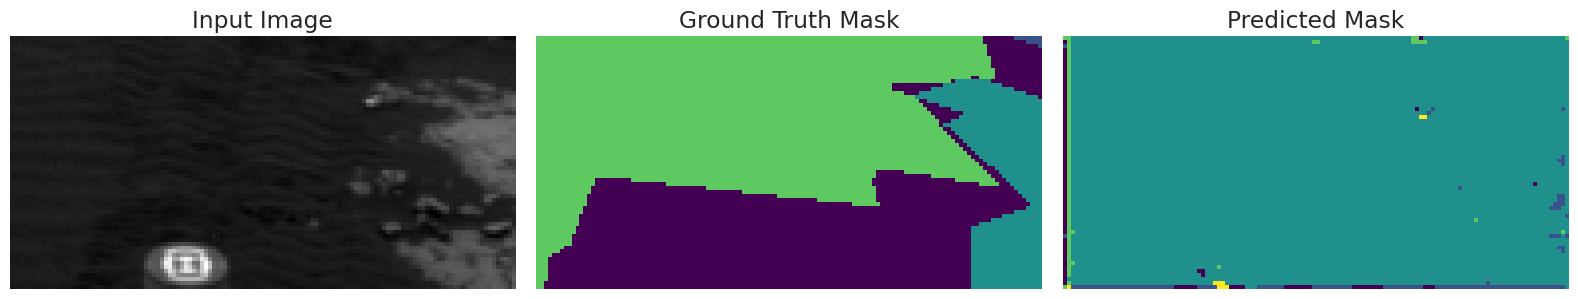

18/18 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.3094 - loss: 4.5042 - mean_iou: 0.1295 - val_accuracy: 0.2233 - val_loss: 4.2071 - val_mean_iou: 0.0658
Epoch 2/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.4189 - loss: 3.5695 - mean_iou: 0.2150 - val_accuracy: 0.3020 - val_loss: 3.7503 - val_mean_iou: 0.1419
Epoch 3/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.5036 - loss: 3.1108 - mean_iou: 0.2752 - val_accuracy: 0.3033 - val_loss: 3.9053 - val_mean_iou: 0.1400
Epoch 4/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.5597 - loss: 2.8786 - mean_iou: 0.3185 - val_accuracy: 0.2717 - val_loss: 4.0104 - val_mean_iou: 0.1069
Epoch 5/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.5925 - loss: 2.7039 - mean_iou: 0.3490 - val_accuracy: 0.2445 - val_loss: 4.0370 - val_mean_iou: 0.0821
Epoch 6/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6147 - loss: 2.5236 - mean_iou: 0.3628

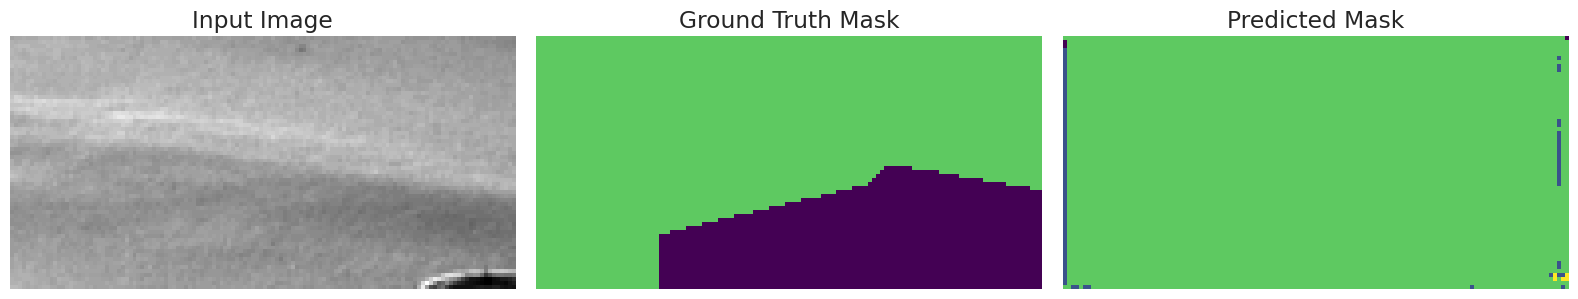

18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.6139 - loss: 2.5351 - mean_iou: 0.3618 - val_accuracy: 0.2454 - val_loss: 4.2890 - val_mean_iou: 0.0808
Epoch 7/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.6290 - loss: 2.5064 - mean_iou: 0.3763 - val_accuracy: 0.2861 - val_loss: 4.3155 - val_mean_iou: 0.1061
Epoch 8/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.6363 - loss: 2.4934 - mean_iou: 0.3805 - val_accuracy: 0.2975 - val_loss: 4.5020 - val_mean_iou: 0.1124
Epoch 9/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.6316 - loss: 2.4824 - mean_iou: 0.3718 - val_accuracy: 0.2340 - val_loss: 5.2165 - val_mean_iou: 0.0688
Epoch 10/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.6335 - loss: 2.4258 - mean_iou: 0.3815 - val_accuracy: 0.3336 - val_loss: 4.4424 - val_mean_iou: 0.1366
Epoch 11/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6429 - loss: 2.3116 - mean_iou: 0.3903

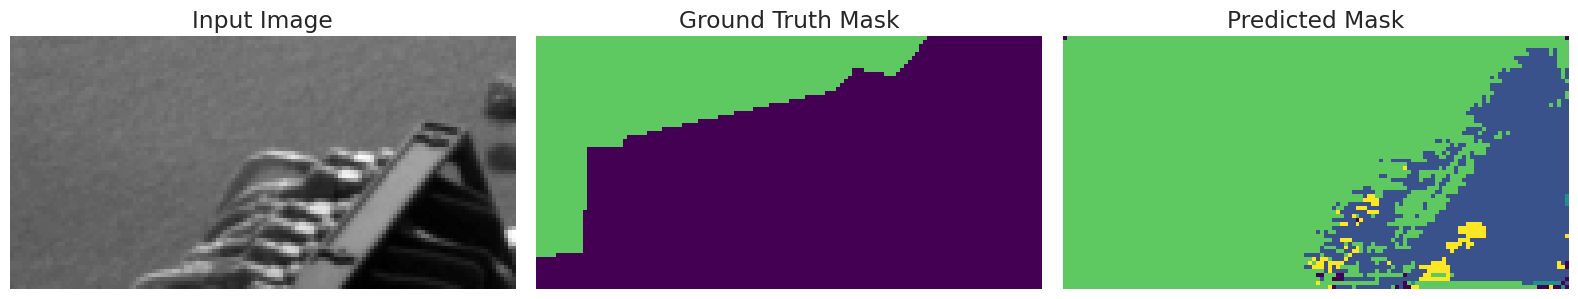

18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.6417 - loss: 2.3247 - mean_iou: 0.3891 - val_accuracy: 0.3712 - val_loss: 4.5866 - val_mean_iou: 0.1604
Epoch 12/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.6687 - loss: 2.2195 - mean_iou: 0.4103 - val_accuracy: 0.4275 - val_loss: 4.0608 - val_mean_iou: 0.2064
Epoch 13/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.6624 - loss: 2.2491 - mean_iou: 0.4078 - val_accuracy: 0.4952 - val_loss: 3.3688 - val_mean_iou: 0.2645
Epoch 14/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.6742 - loss: 2.1397 - mean_iou: 0.4253 - val_accuracy: 0.4992 - val_loss: 3.3893 - val_mean_iou: 0.2607
Epoch 15/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.6780 - loss: 2.1590 - mean_iou: 0.4165 - val_accuracy: 0.4462 - val_loss: 3.9038 - val_mean_iou: 0.2156
Epoch 16/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6737 - loss: 2.1761 - mean_iou: 0.4146

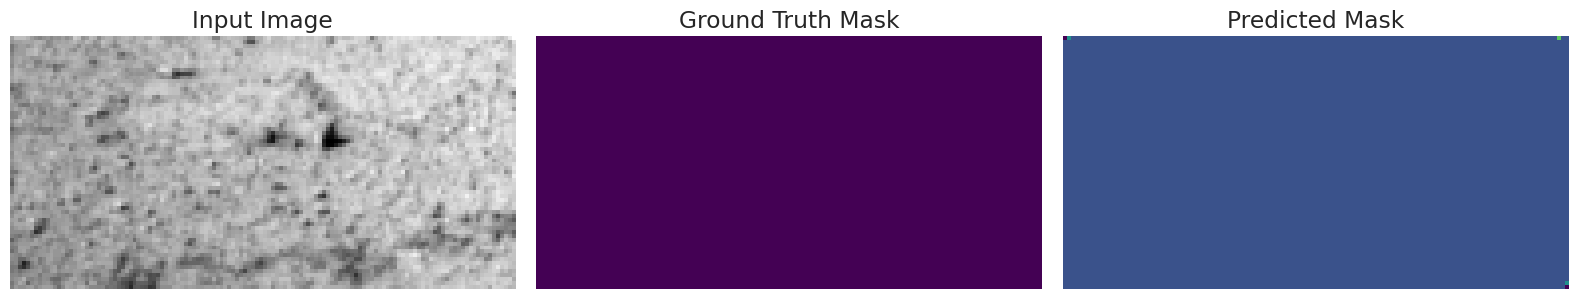

18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.6726 - loss: 2.1875 - mean_iou: 0.4132 - val_accuracy: 0.5307 - val_loss: 3.1219 - val_mean_iou: 0.2848
Epoch 17/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.6971 - loss: 2.0387 - mean_iou: 0.4281 - val_accuracy: 0.5248 - val_loss: 3.4515 - val_mean_iou: 0.2683
Epoch 18/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.6921 - loss: 2.0368 - mean_iou: 0.4307 - val_accuracy: 0.5324 - val_loss: 3.2458 - val_mean_iou: 0.2905
Epoch 19/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.6970 - loss: 2.0214 - mean_iou: 0.4382 - val_accuracy: 0.5323 - val_loss: 3.1241 - val_mean_iou: 0.2992
Epoch 20/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7097 - loss: 1.9882 - mean_iou: 0.4562 - val_accuracy: 0.5710 - val_loss: 3.3090 - val_mean_iou: 0.3214
Epoch 21/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6895 - loss: 2.0448 - mean_iou: 0.4319

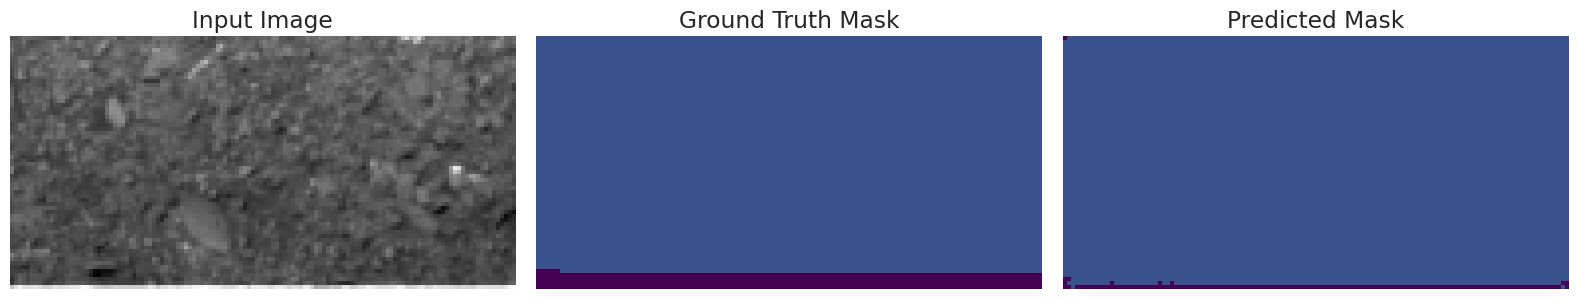

18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.6878 - loss: 2.0621 - mean_iou: 0.4299 - val_accuracy: 0.5900 - val_loss: 3.0841 - val_mean_iou: 0.3023
Epoch 22/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.6999 - loss: 2.0062 - mean_iou: 0.4397 - val_accuracy: 0.5906 - val_loss: 2.7110 - val_mean_iou: 0.3155
Epoch 23/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7076 - loss: 1.9470 - mean_iou: 0.4429 - val_accuracy: 0.5102 - val_loss: 3.3715 - val_mean_iou: 0.2845
Epoch 24/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.7113 - loss: 1.9391 - mean_iou: 0.4586 - val_accuracy: 0.5960 - val_loss: 2.8097 - val_mean_iou: 0.3499
Epoch 25/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.7176 - loss: 1.8694 - mean_iou: 0.4604 - val_accuracy: 0.5903 - val_loss: 3.0311 - val_mean_iou: 0.3428
Epoch 26/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7034 - loss: 1.9708 - mean_iou: 0.4572

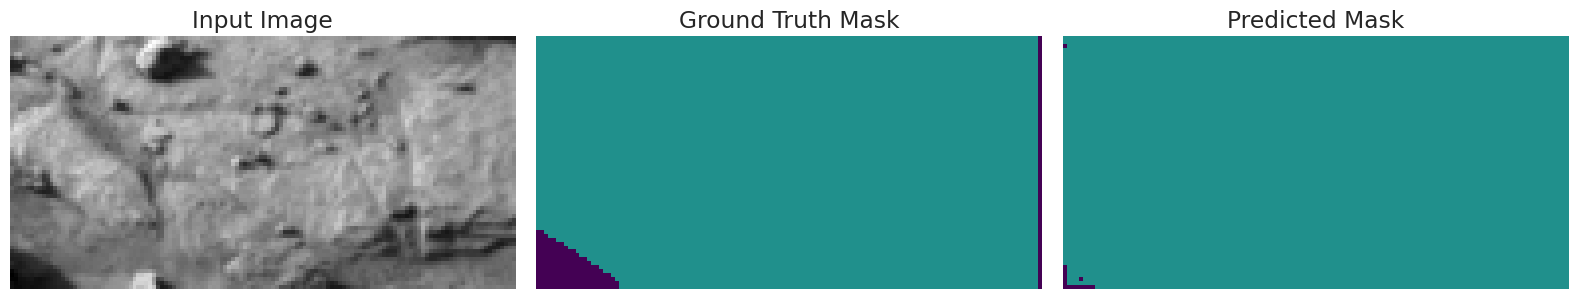

18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.7018 - loss: 1.9883 - mean_iou: 0.4550 - val_accuracy: 0.6037 - val_loss: 2.9297 - val_mean_iou: 0.3469
Epoch 27/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7137 - loss: 1.9003 - mean_iou: 0.4589 - val_accuracy: 0.5674 - val_loss: 3.0525 - val_mean_iou: 0.3150
Epoch 28/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7058 - loss: 1.9821 - mean_iou: 0.4327 - val_accuracy: 0.5743 - val_loss: 3.0872 - val_mean_iou: 0.2989
Epoch 29/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7227 - loss: 1.8875 - mean_iou: 0.4475 - val_accuracy: 0.5711 - val_loss: 2.9170 - val_mean_iou: 0.2933
Epoch 30/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7364 - loss: 1.8066 - mean_iou: 0.4727 - val_accuracy: 0.5518 - val_loss: 3.0349 - val_mean_iou: 0.2995
Epoch 31/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7421 - loss: 1.7700 - mean_iou: 0.4844

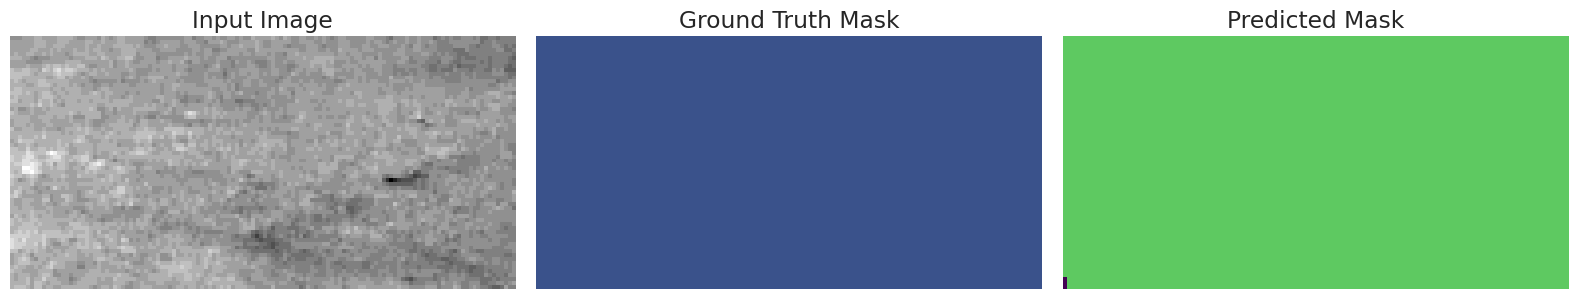

18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.7404 - loss: 1.7868 - mean_iou: 0.4824 - val_accuracy: 0.6136 - val_loss: 2.8822 - val_mean_iou: 0.3389
Epoch 32/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.7475 - loss: 1.6925 - mean_iou: 0.4871 - val_accuracy: 0.5698 - val_loss: 2.8641 - val_mean_iou: 0.2887
Epoch 33/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7627 - loss: 1.6268 - mean_iou: 0.5088 - val_accuracy: 0.5828 - val_loss: 2.9420 - val_mean_iou: 0.3088
Epoch 34/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7635 - loss: 1.7217 - mean_iou: 0.4919 - val_accuracy: 0.2048 - val_loss: 8.4827 - val_mean_iou: 0.1049
Epoch 35/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7043 - loss: 1.9156 - mean_iou: 0.4366 - val_accuracy: 0.4381 - val_loss: 3.8457 - val_mean_iou: 0.2221
Epoch 36/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7431 - loss: 1.7366 - mean_iou: 0.4734

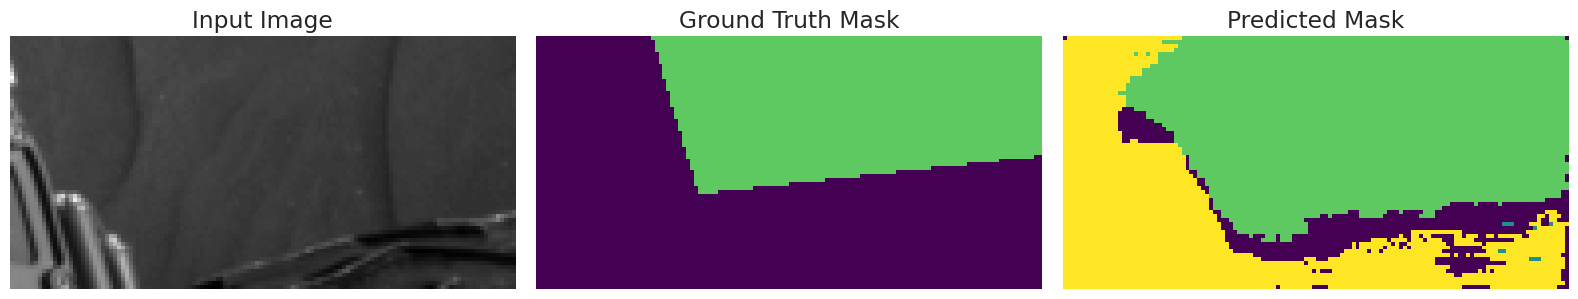

18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.7409 - loss: 1.7555 - mean_iou: 0.4711 - val_accuracy: 0.4547 - val_loss: 3.9163 - val_mean_iou: 0.2818
Epoch 37/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7359 - loss: 1.7233 - mean_iou: 0.4701 - val_accuracy: 0.6107 - val_loss: 2.8629 - val_mean_iou: 0.3437
Epoch 38/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7582 - loss: 1.6304 - mean_iou: 0.4907 - val_accuracy: 0.6205 - val_loss: 2.7716 - val_mean_iou: 0.3367
Epoch 39/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7702 - loss: 1.5754 - mean_iou: 0.5043 - val_accuracy: 0.6113 - val_loss: 2.8318 - val_mean_iou: 0.3431
Epoch 40/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.7708 - loss: 1.5839 - mean_iou: 0.5015 - val_accuracy: 0.5541 - val_loss: 3.3579 - val_mean_iou: 0.3115
Epoch 41/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7433 - loss: 1.7059 - mean_iou: 0.4697

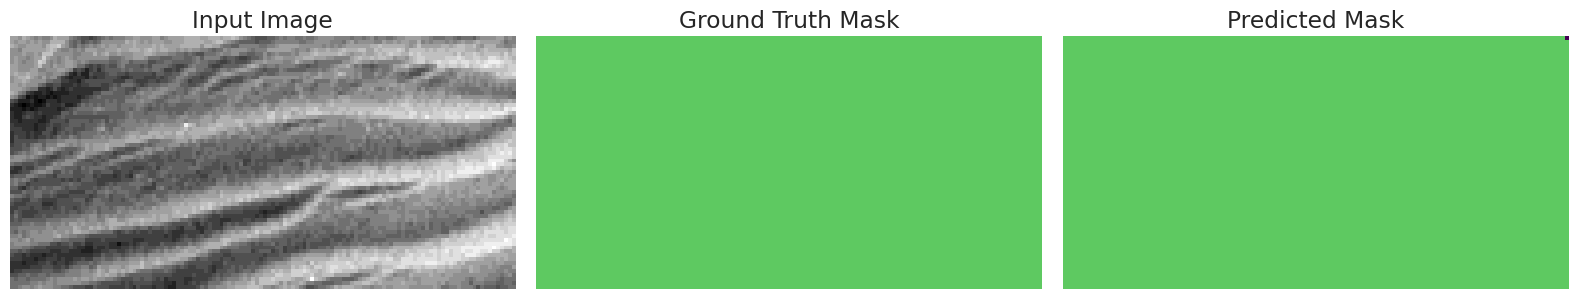

18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.7415 - loss: 1.7198 - mean_iou: 0.4676 - val_accuracy: 0.5929 - val_loss: 2.7601 - val_mean_iou: 0.3201
Epoch 42/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7638 - loss: 1.6152 - mean_iou: 0.5157 - val_accuracy: 0.6041 - val_loss: 2.6065 - val_mean_iou: 0.3423
Epoch 43/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7694 - loss: 1.5932 - mean_iou: 0.5130 - val_accuracy: 0.6491 - val_loss: 2.5591 - val_mean_iou: 0.3673
Epoch 44/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7676 - loss: 1.5335 - mean_iou: 0.4959 - val_accuracy: 0.5956 - val_loss: 3.0434 - val_mean_iou: 0.3321
Epoch 45/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7862 - loss: 1.5235 - mean_iou: 0.5235 - val_accuracy: 0.6346 - val_loss: 2.7332 - val_mean_iou: 0.3338
Epoch 46/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7811 - loss: 1.4791 - mean_iou: 0.5152

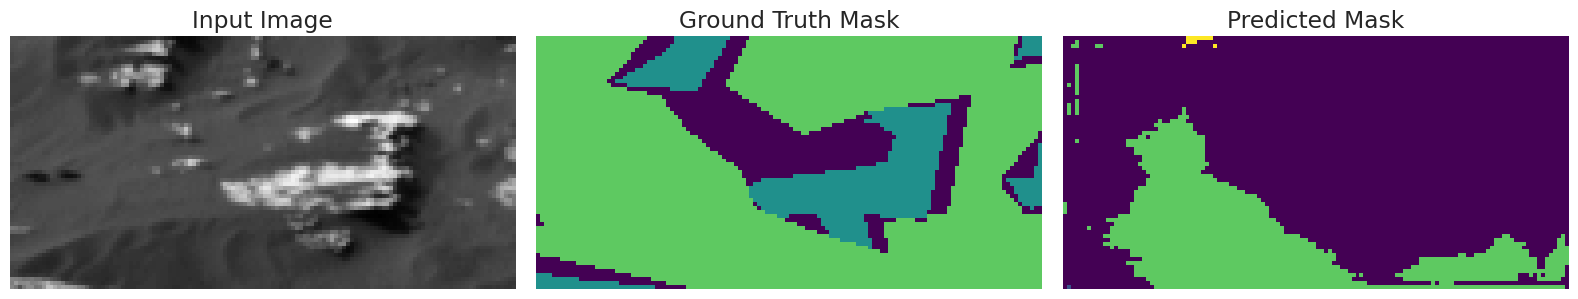

18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7788 - loss: 1.4956 - mean_iou: 0.5124 - val_accuracy: 0.5985 - val_loss: 2.9027 - val_mean_iou: 0.3090
Epoch 47/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7862 - loss: 1.4843 - mean_iou: 0.5180 - val_accuracy: 0.4978 - val_loss: 3.5820 - val_mean_iou: 0.2814
Epoch 48/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7685 - loss: 1.6226 - mean_iou: 0.4954 - val_accuracy: 0.5986 - val_loss: 2.8881 - val_mean_iou: 0.3169
Epoch 49/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7719 - loss: 1.5804 - mean_iou: 0.4968 - val_accuracy: 0.6503 - val_loss: 2.8627 - val_mean_iou: 0.3591
Epoch 50/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7756 - loss: 1.5406 - mean_iou: 0.4896 - val_accuracy: 0.5609 - val_loss: 3.3714 - val_mean_iou: 0.2785
Epoch 51/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7773 - loss: 1.5185 - mean_iou: 0.5076

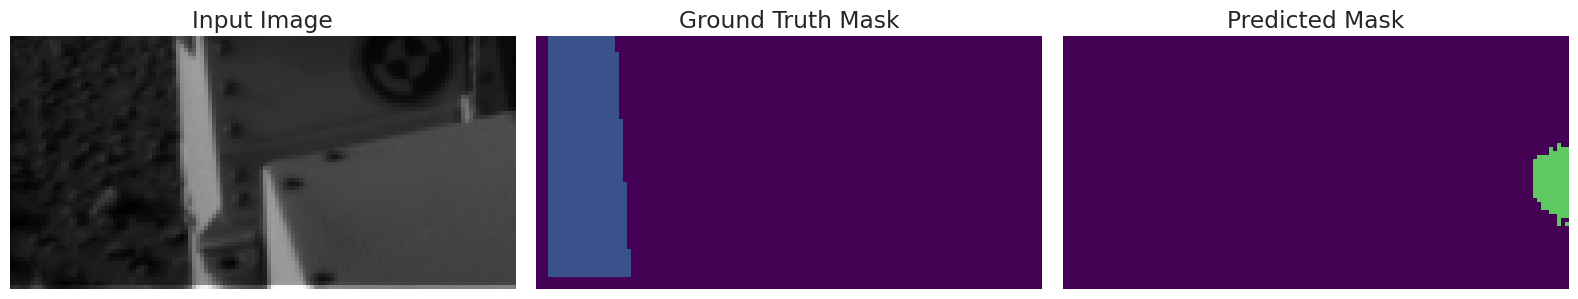

18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7752 - loss: 1.5390 - mean_iou: 0.5051 - val_accuracy: 0.6038 - val_loss: 3.2582 - val_mean_iou: 0.3518
Epoch 52/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7689 - loss: 1.5519 - mean_iou: 0.5019 - val_accuracy: 0.6042 - val_loss: 2.7606 - val_mean_iou: 0.3296
Epoch 53/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7819 - loss: 1.4615 - mean_iou: 0.4982 - val_accuracy: 0.5299 - val_loss: 3.4330 - val_mean_iou: 0.2934
Epoch 54/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7941 - loss: 1.4214 - mean_iou: 0.5240 - val_accuracy: 0.5892 - val_loss: 3.0787 - val_mean_iou: 0.3194
Epoch 55/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7810 - loss: 1.4783 - mean_iou: 0.5070 - val_accuracy: 0.6369 - val_loss: 2.5254 - val_mean_iou: 0.3544
Epoch 56/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7764 - loss: 1.4601 - mean_iou: 0.5107

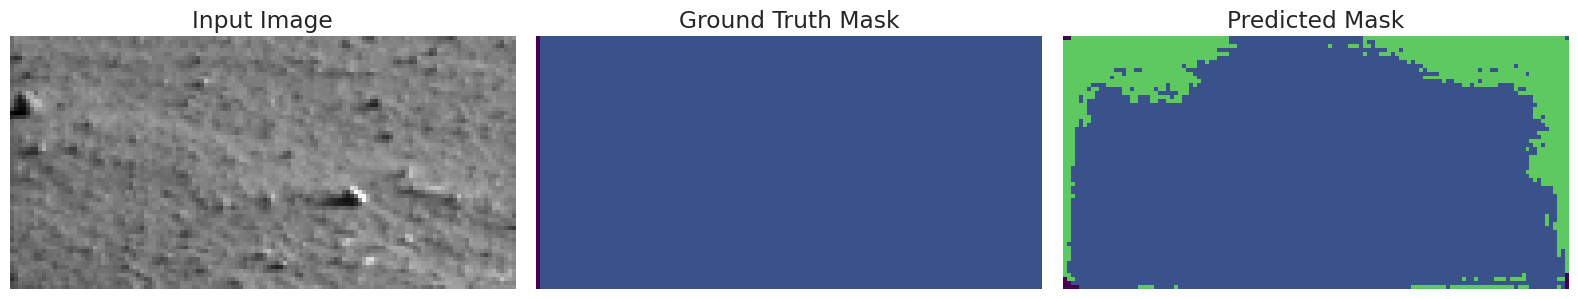

18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.7742 - loss: 1.4754 - mean_iou: 0.5081 - val_accuracy: 0.5678 - val_loss: 2.9355 - val_mean_iou: 0.3228
Epoch 57/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7934 - loss: 1.4096 - mean_iou: 0.5233 - val_accuracy: 0.6306 - val_loss: 2.6893 - val_mean_iou: 0.3355
Epoch 58/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7989 - loss: 1.4163 - mean_iou: 0.5117 - val_accuracy: 0.4922 - val_loss: 3.6573 - val_mean_iou: 0.2684
Epoch 59/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7617 - loss: 1.5562 - mean_iou: 0.5006 - val_accuracy: 0.4731 - val_loss: 3.7294 - val_mean_iou: 0.1931
Epoch 60/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7612 - loss: 1.6780 - mean_iou: 0.4775 - val_accuracy: 0.3712 - val_loss: 4.9411 - val_mean_iou: 0.1926
Epoch 61/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7807 - loss: 1.4975 - mean_iou: 0.5117

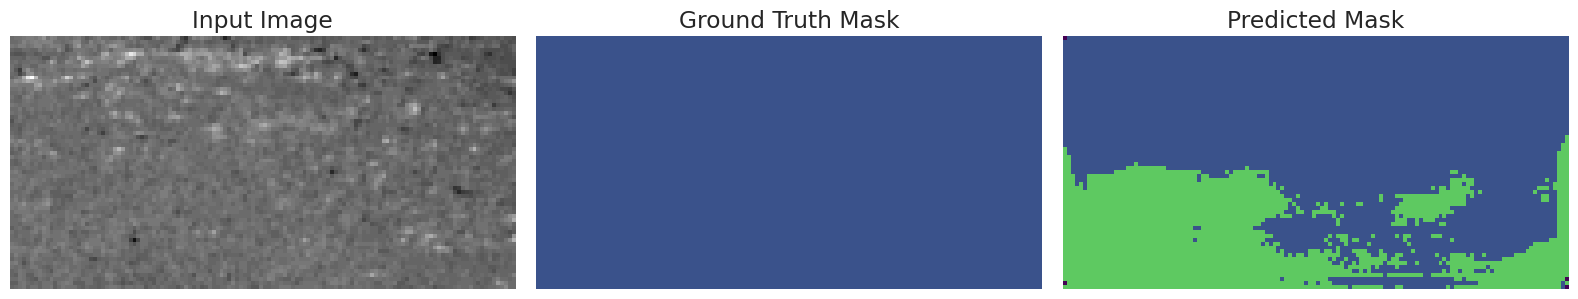

18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.7784 - loss: 1.5170 - mean_iou: 0.5093 - val_accuracy: 0.5668 - val_loss: 3.1417 - val_mean_iou: 0.2972
Epoch 62/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.7954 - loss: 1.4038 - mean_iou: 0.5312 - val_accuracy: 0.6092 - val_loss: 2.8546 - val_mean_iou: 0.3286
Epoch 63/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7864 - loss: 1.4686 - mean_iou: 0.5194 - val_accuracy: 0.5551 - val_loss: 3.3267 - val_mean_iou: 0.2617
Epoch 64/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7791 - loss: 1.4852 - mean_iou: 0.4918 - val_accuracy: 0.5784 - val_loss: 3.3330 - val_mean_iou: 0.3098
Epoch 65/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7968 - loss: 1.4015 - mean_iou: 0.5148 - val_accuracy: 0.6157 - val_loss: 2.9907 - val_mean_iou: 0.3334
Epoch 66/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8128 - loss: 1.3186 - mean_iou: 0.5300

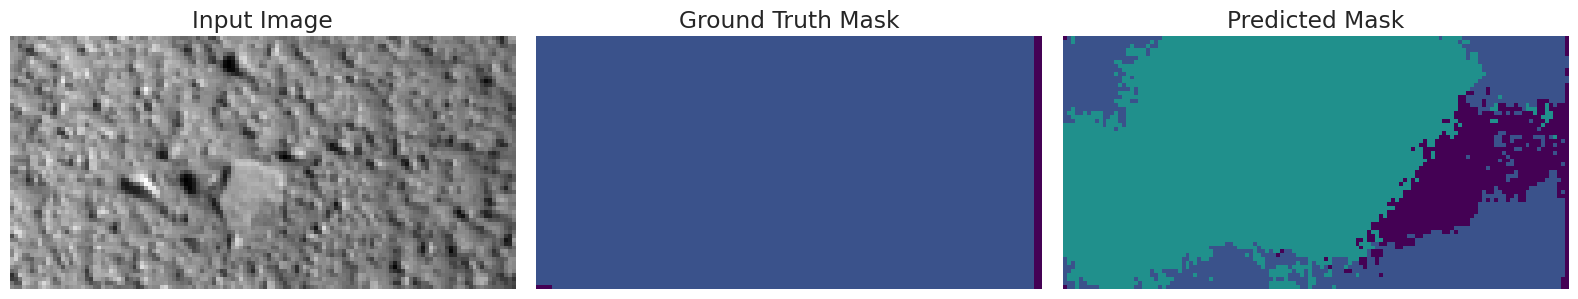

18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8102 - loss: 1.3397 - mean_iou: 0.5272 - val_accuracy: 0.5950 - val_loss: 3.0074 - val_mean_iou: 0.3516
Epoch 67/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8102 - loss: 1.3143 - mean_iou: 0.5208 - val_accuracy: 0.5799 - val_loss: 3.2368 - val_mean_iou: 0.3383
Epoch 68/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8222 - loss: 1.2166 - mean_iou: 0.5471 - val_accuracy: 0.6378 - val_loss: 2.6324 - val_mean_iou: 0.3644
Epoch 69/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.8236 - loss: 1.2969 - mean_iou: 0.5552 - val_accuracy: 0.5306 - val_loss: 3.0902 - val_mean_iou: 0.3240
Epoch 70/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7713 - loss: 1.4927 - mean_iou: 0.4958 - val_accuracy: 0.5050 - val_loss: 3.4709 - val_mean_iou: 0.2542
Epoch 71/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7865 - loss: 1.3965 - mean_iou: 0.5195

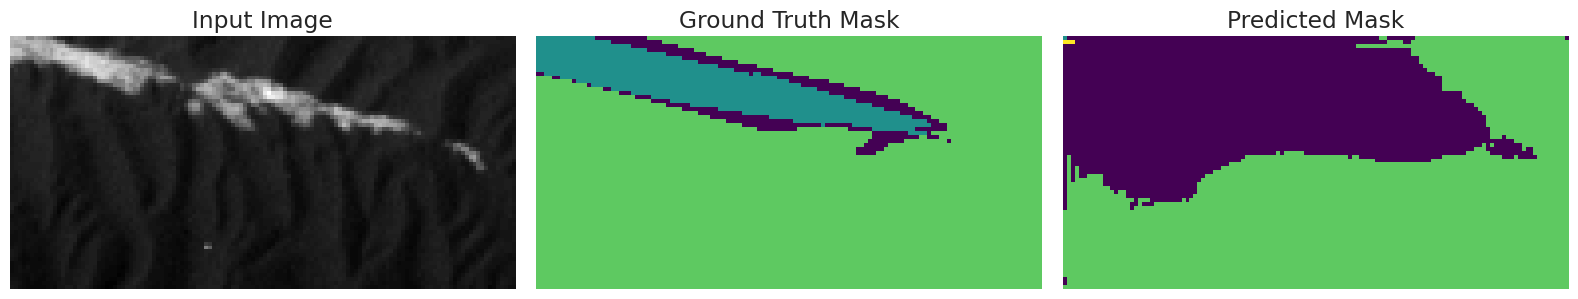

18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.7846 - loss: 1.4156 - mean_iou: 0.5169 - val_accuracy: 0.5599 - val_loss: 2.8145 - val_mean_iou: 0.2750
Epoch 72/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8136 - loss: 1.2790 - mean_iou: 0.5355 - val_accuracy: 0.5237 - val_loss: 3.7681 - val_mean_iou: 0.3044
Epoch 73/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8014 - loss: 1.3249 - mean_iou: 0.5438 - val_accuracy: 0.6409 - val_loss: 2.6601 - val_mean_iou: 0.3702
Epoch 74/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8208 - loss: 1.2389 - mean_iou: 0.5525 - val_accuracy: 0.6440 - val_loss: 2.5620 - val_mean_iou: 0.3708
Epoch 75/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8278 - loss: 1.2004 - mean_iou: 0.5541 - val_accuracy: 0.5938 - val_loss: 2.5797 - val_mean_iou: 0.3265
Epoch 76/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8334 - loss: 1.1428 - mean_iou: 0.5546

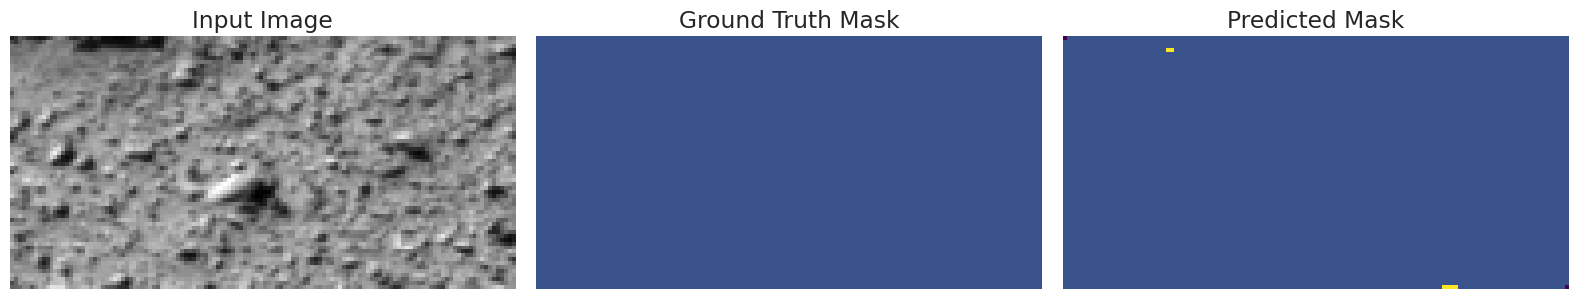

18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.8305 - loss: 1.1617 - mean_iou: 0.5513 - val_accuracy: 0.6546 - val_loss: 2.5909 - val_mean_iou: 0.3762
Epoch 77/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.8354 - loss: 1.1707 - mean_iou: 0.5587 - val_accuracy: 0.6658 - val_loss: 2.5726 - val_mean_iou: 0.3785
Epoch 78/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.8366 - loss: 1.2360 - mean_iou: 0.5851 - val_accuracy: 0.5234 - val_loss: 3.5056 - val_mean_iou: 0.2590
Epoch 79/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.8001 - loss: 1.4077 - mean_iou: 0.5080 - val_accuracy: 0.5282 - val_loss: 3.7393 - val_mean_iou: 0.2532
Epoch 80/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.7974 - loss: 1.3590 - mean_iou: 0.5097 - val_accuracy: 0.6468 - val_loss: 2.6148 - val_mean_iou: 0.3545
Epoch 81/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8309 - loss: 1.1775 - mean_iou: 0.5669

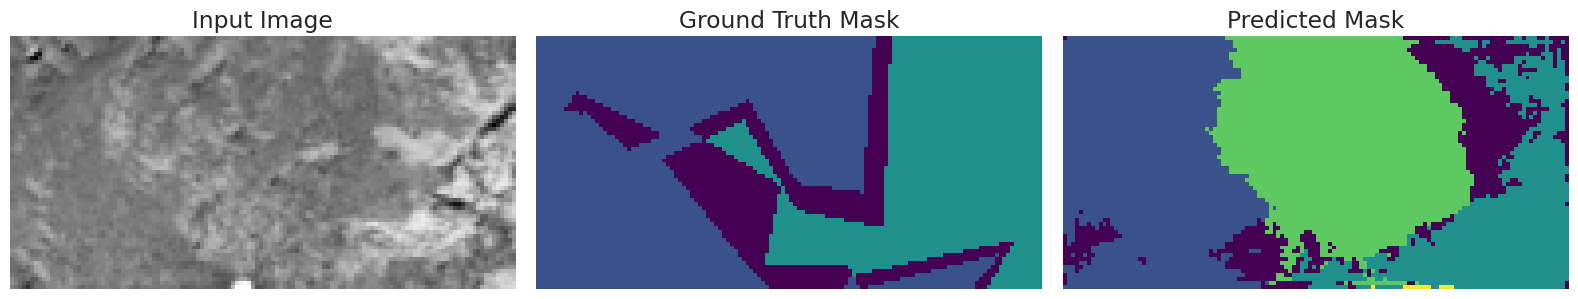

18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.8285 - loss: 1.1979 - mean_iou: 0.5636 - val_accuracy: 0.6543 - val_loss: 2.3637 - val_mean_iou: 0.3764
Epoch 82/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8441 - loss: 1.1098 - mean_iou: 0.5767 - val_accuracy: 0.6487 - val_loss: 2.7895 - val_mean_iou: 0.3638
Epoch 83/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8466 - loss: 1.1111 - mean_iou: 0.5870 - val_accuracy: 0.5907 - val_loss: 3.1418 - val_mean_iou: 0.3354
Epoch 84/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8468 - loss: 1.1151 - mean_iou: 0.5715 - val_accuracy: 0.6669 - val_loss: 2.5153 - val_mean_iou: 0.3656
Epoch 85/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.8520 - loss: 1.1018 - mean_iou: 0.5604 - val_accuracy: 0.6727 - val_loss: 2.4208 - val_mean_iou: 0.3705
Epoch 86/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8477 - loss: 1.0691 - mean_iou: 0.5665

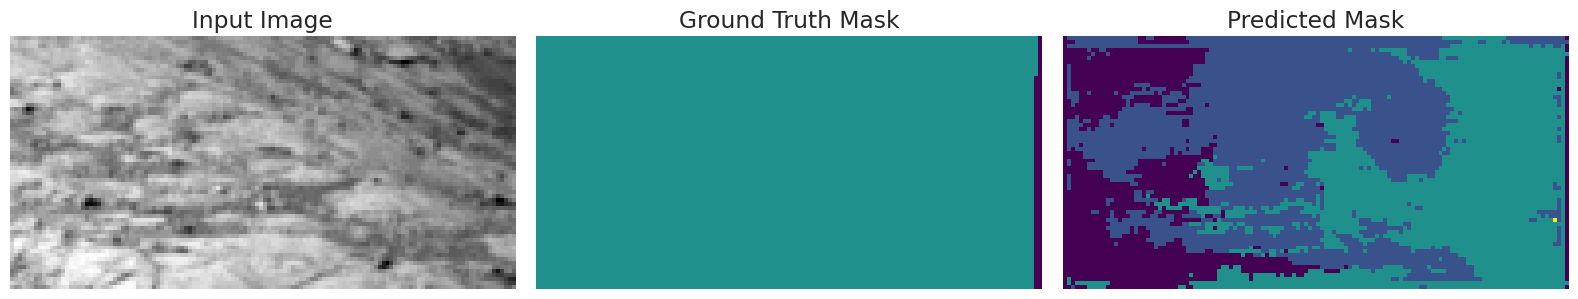

18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8448 - loss: 1.0904 - mean_iou: 0.5631 - val_accuracy: 0.6303 - val_loss: 2.7888 - val_mean_iou: 0.3411
Epoch 87/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8396 - loss: 1.0940 - mean_iou: 0.5797 - val_accuracy: 0.6307 - val_loss: 3.2344 - val_mean_iou: 0.3331
Epoch 88/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8476 - loss: 1.0995 - mean_iou: 0.5935 - val_accuracy: 0.6260 - val_loss: 2.8096 - val_mean_iou: 0.3353
Epoch 89/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8516 - loss: 1.0536 - mean_iou: 0.5751 - val_accuracy: 0.6209 - val_loss: 2.9436 - val_mean_iou: 0.3188
Epoch 90/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8587 - loss: 1.0064 - mean_iou: 0.6117 - val_accuracy: 0.6470 - val_loss: 2.7611 - val_mean_iou: 0.3574
Epoch 91/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8641 - loss: 0.9646 - mean_iou: 0.6172

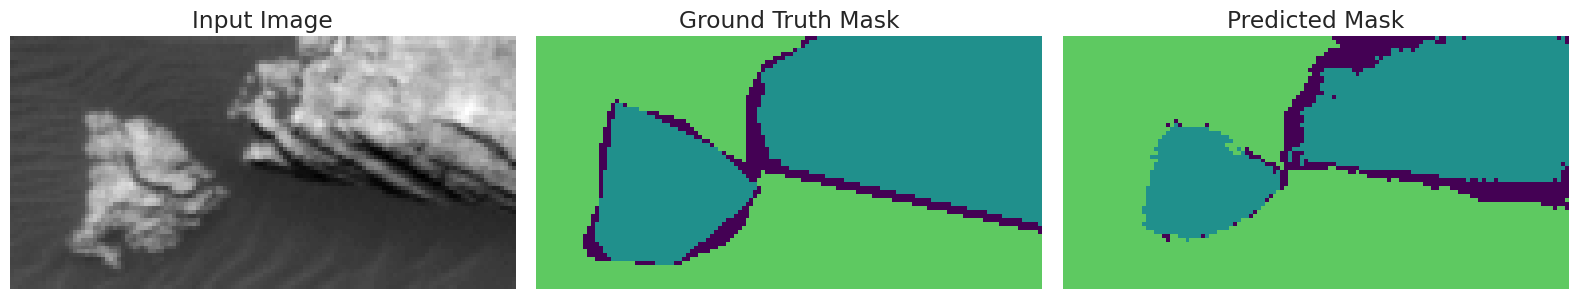

18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.8611 - loss: 0.9854 - mean_iou: 0.6122 - val_accuracy: 0.6712 - val_loss: 2.2866 - val_mean_iou: 0.3898
Epoch 92/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8609 - loss: 1.0435 - mean_iou: 0.6098 - val_accuracy: 0.6254 - val_loss: 3.8321 - val_mean_iou: 0.3433
Epoch 93/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.8529 - loss: 1.0868 - mean_iou: 0.5653 - val_accuracy: 0.5605 - val_loss: 3.3969 - val_mean_iou: 0.3108
Epoch 94/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8063 - loss: 1.3352 - mean_iou: 0.5148 - val_accuracy: 0.6281 - val_loss: 2.9716 - val_mean_iou: 0.3382
Epoch 95/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8382 - loss: 1.1337 - mean_iou: 0.5702 - val_accuracy: 0.6690 - val_loss: 2.3696 - val_mean_iou: 0.4017
Epoch 96/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8583 - loss: 1.0318 - mean_iou: 0.5687

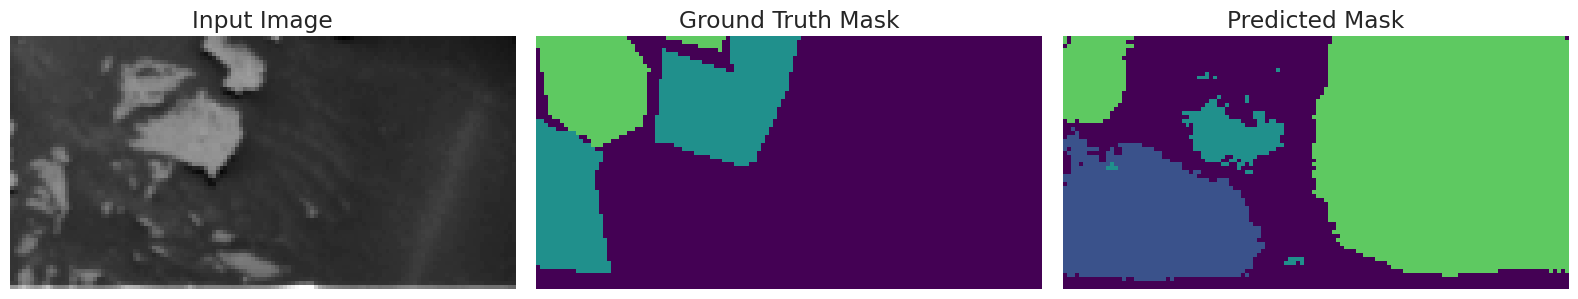

18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.8555 - loss: 1.0508 - mean_iou: 0.5653 - val_accuracy: 0.6598 - val_loss: 2.7505 - val_mean_iou: 0.4062
Epoch 97/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8610 - loss: 0.9995 - mean_iou: 0.6034 - val_accuracy: 0.6289 - val_loss: 3.0733 - val_mean_iou: 0.3800
Epoch 98/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8627 - loss: 0.9879 - mean_iou: 0.5851 - val_accuracy: 0.6470 - val_loss: 2.6028 - val_mean_iou: 0.3724
Epoch 99/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8608 - loss: 0.9997 - mean_iou: 0.5819 - val_accuracy: 0.6684 - val_loss: 2.5703 - val_mean_iou: 0.3744
Epoch 100/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8666 - loss: 0.9671 - mean_iou: 0.6179 - val_accuracy: 0.5192 - val_loss: 3.2197 - val_mean_iou: 0.3206
Epoch 101/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8580 - loss: 1.0477 - mean_iou: 0.5782

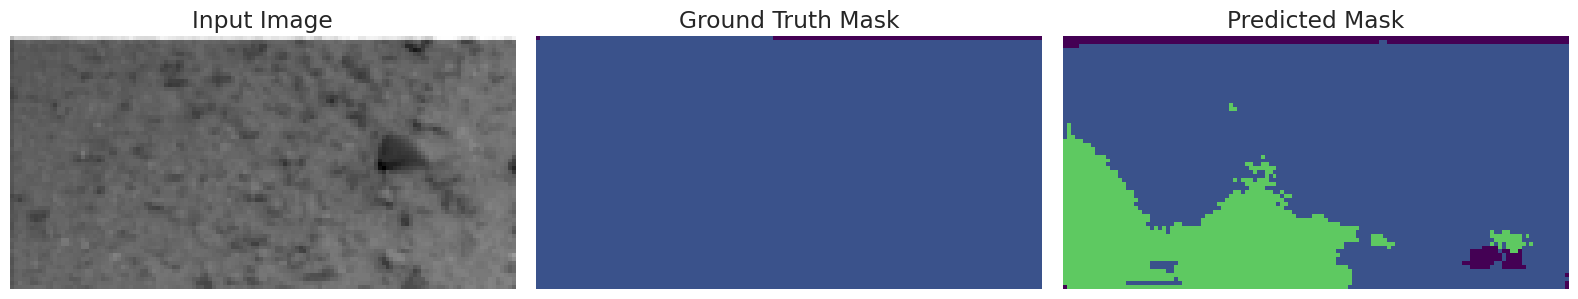

18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.8550 - loss: 1.0725 - mean_iou: 0.5743 - val_accuracy: 0.5953 - val_loss: 3.2441 - val_mean_iou: 0.3111
Epoch 102/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8507 - loss: 1.0374 - mean_iou: 0.5495 - val_accuracy: 0.6483 - val_loss: 2.6693 - val_mean_iou: 0.3684
Epoch 103/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8656 - loss: 0.9865 - mean_iou: 0.5977 - val_accuracy: 0.6208 - val_loss: 2.6422 - val_mean_iou: 0.3484
Epoch 104/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8579 - loss: 1.0231 - mean_iou: 0.5732 - val_accuracy: 0.3279 - val_loss: 5.9592 - val_mean_iou: 0.2272
Epoch 105/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.8464 - loss: 1.1300 - mean_iou: 0.5689 - val_accuracy: 0.6097 - val_loss: 2.7888 - val_mean_iou: 0.3230
Epoch 106/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8573 - loss: 1.0452 - mean_iou: 0.5804

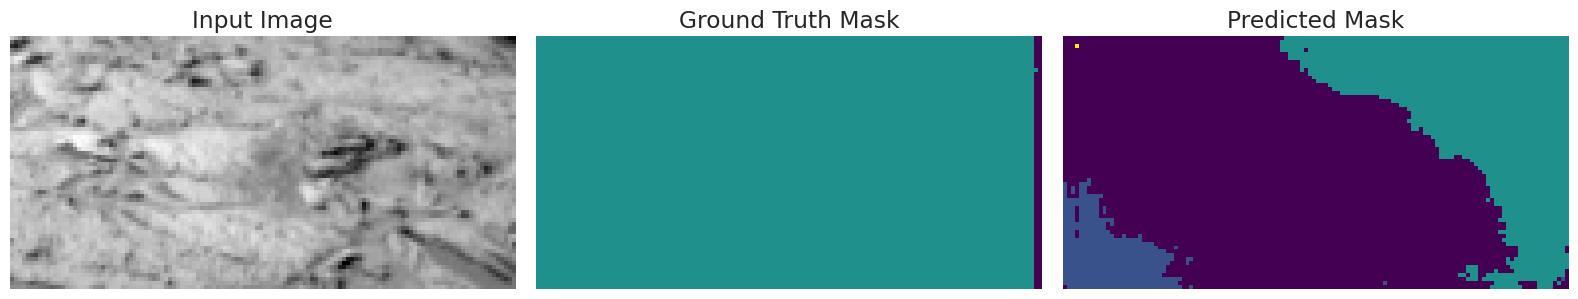

18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.8544 - loss: 1.0665 - mean_iou: 0.5765 - val_accuracy: 0.5342 - val_loss: 3.3039 - val_mean_iou: 0.2609
Epoch 107/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.8616 - loss: 1.0082 - mean_iou: 0.5856 - val_accuracy: 0.6078 - val_loss: 3.2198 - val_mean_iou: 0.3044
Epoch 108/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.8494 - loss: 1.0800 - mean_iou: 0.5644 - val_accuracy: 0.4900 - val_loss: 3.3943 - val_mean_iou: 0.2510
Epoch 109/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.8636 - loss: 0.9894 - mean_iou: 0.5908 - val_accuracy: 0.6217 - val_loss: 2.8743 - val_mean_iou: 0.3417
Epoch 110/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8629 - loss: 0.9854 - mean_iou: 0.5979 - val_accuracy: 0.6228 - val_loss: 3.1524 - val_mean_iou: 0.3140
Epoch 111/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8319 - loss: 1.1446 - mean_iou: 0.5725

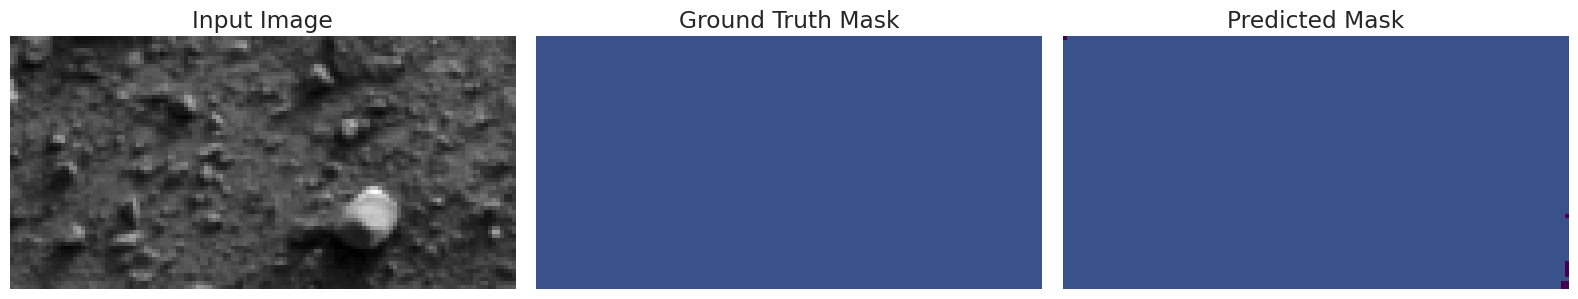

18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.8289 - loss: 1.1694 - mean_iou: 0.5682 - val_accuracy: 0.6200 - val_loss: 3.2332 - val_mean_iou: 0.3188
Epoch 112/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.8346 - loss: 1.1823 - mean_iou: 0.5383 - val_accuracy: 0.6586 - val_loss: 2.7103 - val_mean_iou: 0.3717
Epoch 113/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8336 - loss: 1.1904 - mean_iou: 0.5510 - val_accuracy: 0.5577 - val_loss: 3.0160 - val_mean_iou: 0.2994
Epoch 114/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8525 - loss: 1.0538 - mean_iou: 0.5632 - val_accuracy: 0.6243 - val_loss: 3.9995 - val_mean_iou: 0.3238
Epoch 115/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.8683 - loss: 0.9525 - mean_iou: 0.6026 - val_accuracy: 0.5888 - val_loss: 3.5214 - val_mean_iou: 0.2740
Final validation Mean Intersection Over Union: 40.62%


In [ ]:
# Train the model
with strategy.scope():
    history = model.fit(
        train_dataset,
        epochs=EPOCHS,
        validation_data=val_dataset,
        callbacks=[early_stopping, viz_callback],
        verbose=1
    ).history

    # Calculate and print the final validation accuracy
    final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
    print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

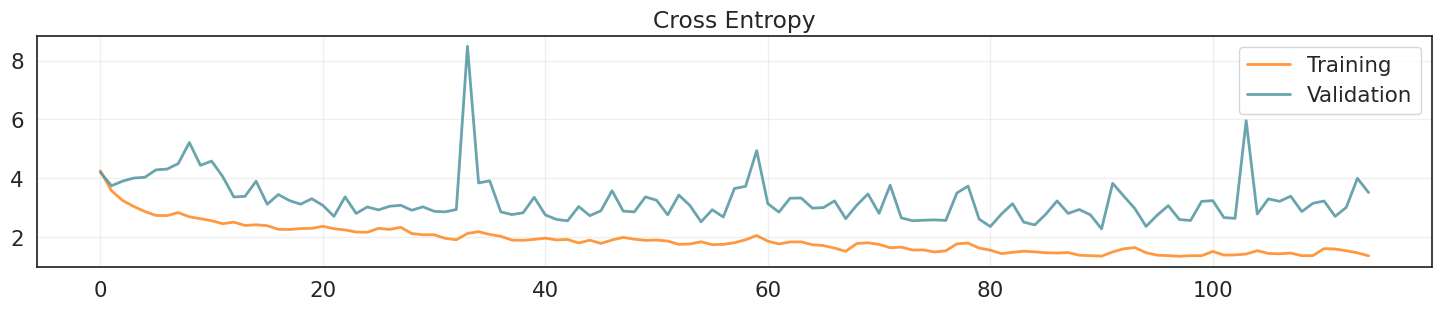

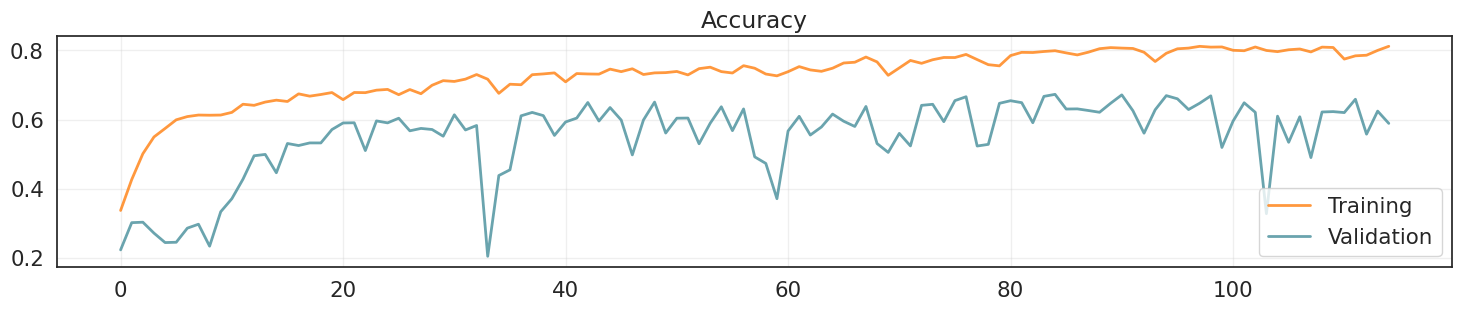

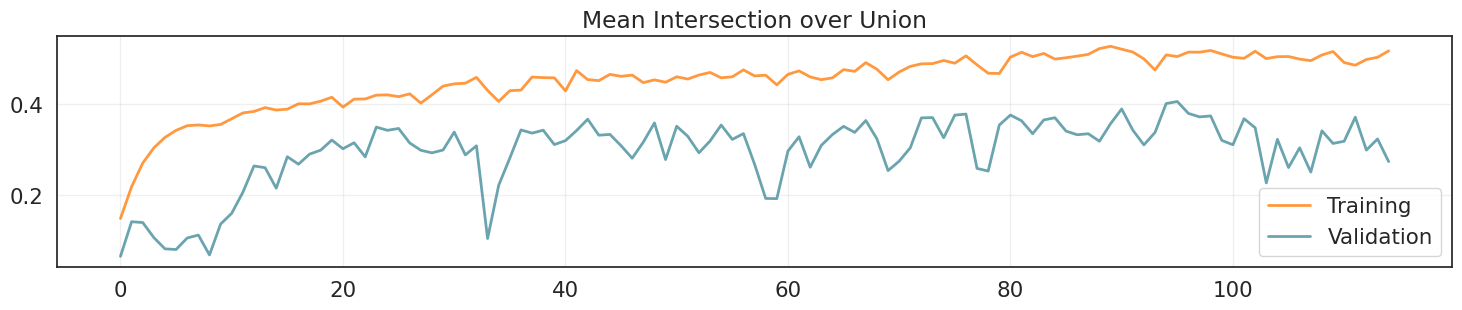

In [ ]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Accuracy for class 0: 51.83%
Accuracy for class 1: 74.41%
Accuracy for class 2: 62.48%
Accuracy for class 3: 78.79%
Accuracy for class 4: 22.22%


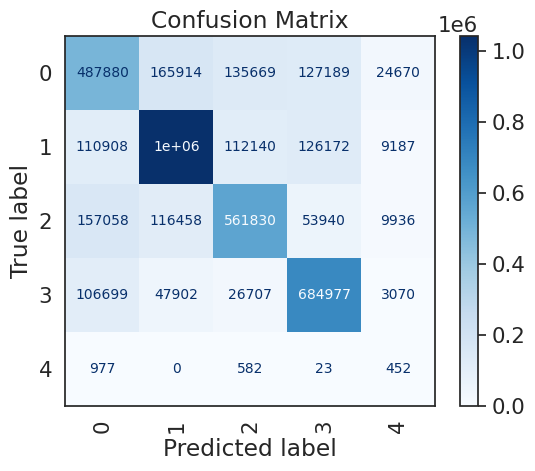

In [ ]:
def plot_confusion_matrix(model, test_data, class_names):
    """
    Plots the confusion matrix for the given model and test data.

    Args:
        model: Trained Keras model.
        test_data: A `tf.data.Dataset` or similar iterable with (inputs, labels).
        class_names: List of class names corresponding to the labels.
    """
    # Get ground-truth labels and model predictions
    y_true = []
    y_pred = []

    for inputs, labels in test_data:
        predictions = model.predict(inputs)
        y_true.extend(np.argmax(labels.numpy(), axis=-1))
        y_pred.extend(np.argmax(predictions, axis=-1))

    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()

    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Calculate accuracy for each class
    class_accuracies = np.diag(cm) / np.sum(cm, axis=1)

    # Print the accuracy for each class
    for i, class_name in enumerate(class_names):
        print(f"Accuracy for class {class_name}: {class_accuracies[i] * 100:.2f}%")

    """# Normalize the confusion matrix by dividing each value by the total number of samples
    total_samples = np.sum(cm)
    cm = cm / total_samples  # Fraction of total samples"""

    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title("Confusion Matrix")

    # Adjust text font size inside each matrix cell
    for label in disp.ax_.texts:
        label.set_fontsize(10)  # Adjust font size of the numbers inside the squares

    plt.show()

plot_confusion_matrix(model, val_dataset, [0, 1,2,3,4])

In [ ]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step
Predictions shape: (10022, 64, 128)


In [ ]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [ ]:
#from time import time

# Create and download the csv submission file
#timestep_str = int(time())
timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

files.download(submission_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>